In [1]:
# Load & Explore the Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
# Set some nicer display options
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [3]:
# Load the main datasets
train = pd.read_csv("../data/train.csv", parse_dates=["date"])
oil = pd.read_csv("../data/oil.csv", parse_dates=["date"])
holidays = pd.read_csv("../data/holidays_events.csv", parse_dates=["date"])
stores = pd.read_csv("../data/stores.csv")

In [4]:
# Quick look at each dataset
print("Train shape:", train.shape)
print("Oil shape:", oil.shape)
print("Holidays shape:", holidays.shape)
print("Stores shape:", stores.shape)

print("\nTrain columns:")
print(train.columns)

# Preview the first few rows
train.head()

Train shape: (3000888, 6)
Oil shape: (1218, 2)
Holidays shape: (350, 6)
Stores shape: (54, 5)

Train columns:
Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
# Data Cleaning & Merging

# Check for missing values
print("Missing values in train:")
print(train.isnull().sum())

Missing values in train:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [6]:
# Merge supporting datasets
# 1. Merge with oil prices
train = train.merge(oil, on="date", how="left")

# 2. Merge with store information
train = train.merge(stores, on="store_nbr", how="left")

# 3. Merge with holidays data
train = train.merge(holidays[["date", "type", "locale", "locale_name", "description", "transferred"]],
                    on="date", how="left")

# Check again
print("\nAfter merging:")
print(train.shape)
print(train.info())
train.head()


After merging:
(3054348, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   dcoilwtico   float64       
 7   city         object        
 8   state        object        
 9   type_x       object        
 10  cluster      int64         
 11  type_y       object        
 12  locale       object        
 13  locale_name  object        
 14  description  object        
 15  transferred  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(9)
memory usage: 372.8+ MB
None


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False


In [7]:
# Feature Preparation 
# Make a copy of the merged 'train' DataFrame we created earlier
df = train.copy()
# Quick check: show top rows and columns
print("Preview of columns and first rows:")
display(df.head())

Preview of columns and first rows:


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False


In [8]:
# Check for Missing values before cleaning
print("\nMissing values (before):")
print(df.isnull().sum())


Missing values (before):
id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
dcoilwtico      955152
city                 0
state                0
type_x               0
cluster              0
type_y         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dtype: int64


In [9]:
# Handle date columns 
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek



In [10]:
# Clean oil price column if present (dcoilwtico)
if 'dcoilwtico' in df.columns:
    df['dcoilwtico'] = pd.to_numeric(df['dcoilwtico'], errors='coerce')
    # forward fill, then backward fill for leading NaNs
    df['dcoilwtico'] = df['dcoilwtico'].ffill()
    df['dcoilwtico'] = df['dcoilwtico'].bfill()

In [11]:
# Fill/handle other common numeric NaNs (example: item_nbr or sales should not be NaN)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns detected:", numeric_cols[:10], "...")
# Show remaining NaNs
print("\nMissing values (after oil/date handling):")
print(df.isnull().sum())


Numeric columns detected: ['id', 'store_nbr', 'sales', 'onpromotion', 'dcoilwtico', 'cluster', 'year', 'month', 'day', 'day_of_week'] ...

Missing values (after oil/date handling):
id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
dcoilwtico           0
city                 0
state                0
type_x               0
cluster              0
type_y         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
year                 0
month                0
day                  0
day_of_week          0
dtype: int64


In [12]:
# Encode categorical features with LabelEncoder (safe for many ML models)
label_cols = [c for c in ['store_nbr', 'family', 'city', 'state', 'type'] if c in df.columns]
print("\nLabel encoding these columns:", label_cols)
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))


Label encoding these columns: ['store_nbr', 'family', 'city', 'state']


In [13]:
# Final missing-values check
print("\nMissing values (final):")
print(df.isnull().sum())


Missing values (final):
id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
dcoilwtico           0
city                 0
state                0
type_x               0
cluster              0
type_y         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
year                 0
month                0
day                  0
day_of_week          0
dtype: int64


In [14]:
# Create a sample for faster experiments (adjust sample_size if needed)
sample_size = 300_000   # change to smaller if your machine is slow
if sample_size and sample_size < len(df):
    df_sample = df.sample(n=sample_size, random_state=42)
else:
    df_sample = df.copy()
print(f"\nSample shape: {df_sample.shape}")


Sample shape: (300000, 20)


In [15]:
# show a quick descriptive summary on the sample
print("\nSample summary (first rows):")
display(df_sample.head())
print("\nSample sales stats:")
display(df_sample['sales'].describe())


Sample summary (first rows):


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred,year,month,day,day_of_week
668753,659843,2014-01-07,15,8,471.0,0,93.31,0,15,D,9,NaN,NaN,NaN,NaN,NaN,2014,1,7,1
1267004,1250966,2014-12-05,0,2,1.0,0,65.89,18,12,D,13,Additional,Local,Quito,Fundacion de Quito-1,False,2014,12,5,4
997442,981404,2014-07-06,39,17,0.0,0,104.76,18,12,A,11,NaN,NaN,NaN,NaN,NaN,2014,7,6,6
873596,864686,2014-05-02,12,20,0.0,0,100.09,18,12,B,6,NaN,NaN,NaN,NaN,NaN,2014,5,2,4
756145,747235,2014-02-25,17,16,0.0,0,102.20,20,13,D,1,NaN,NaN,NaN,NaN,NaN,2014,2,25,1



Sample sales stats:


count    300000.000000
mean        359.205464
std        1102.685029
min           0.000000
25%           0.000000
50%          11.000000
75%         198.000000
max       87438.516000
Name: sales, dtype: float64

In [16]:
# Exploratory Data Analysis EDA
# Set visualization style
sns.set(style="whitegrid", palette="crest", rc={"figure.figsize": (10,6)})

#### core EDA (Exploratory Data Analysis) skills:
1. Loading and merging multiple real-world datasets
2. Handling missing data and types
3. Creating new time-based features
4. Encoding categorical variables
5. Sampling and exploring distributions
6. Plotting and interpreting trends

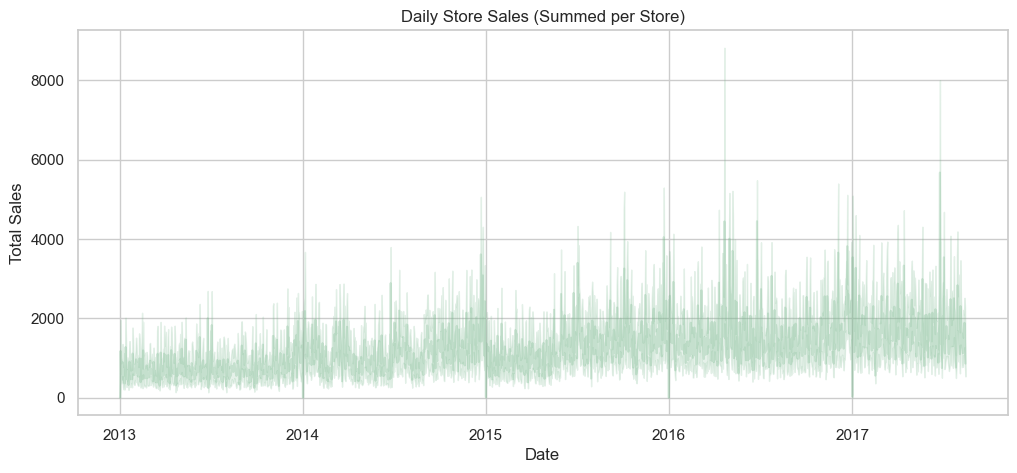

In [17]:
# Aggregate by date and store
daily_store_sales = df_sample.groupby(['date', 'store_nbr'])['sales'].sum().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(data=daily_store_sales, x='date', y='sales', alpha=0.3)
plt.title("Daily Store Sales (Summed per Store)")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()

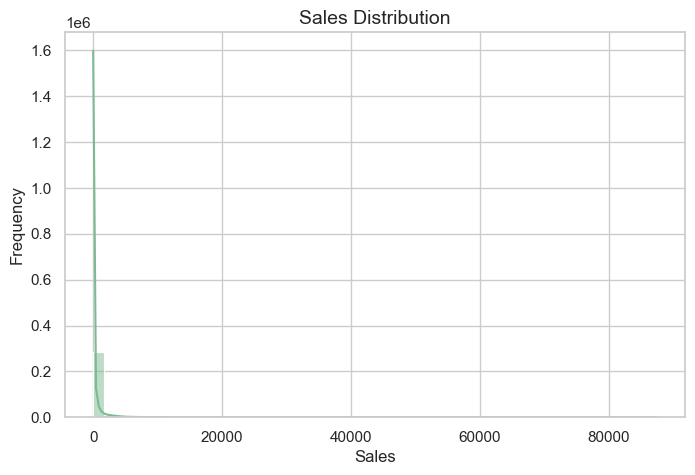

In [18]:
# Sales Distribution
plt.figure(figsize=(8,5))
sns.histplot(df_sample['sales'], bins=50, kde=True)
plt.title("Sales Distribution", fontsize=14)
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

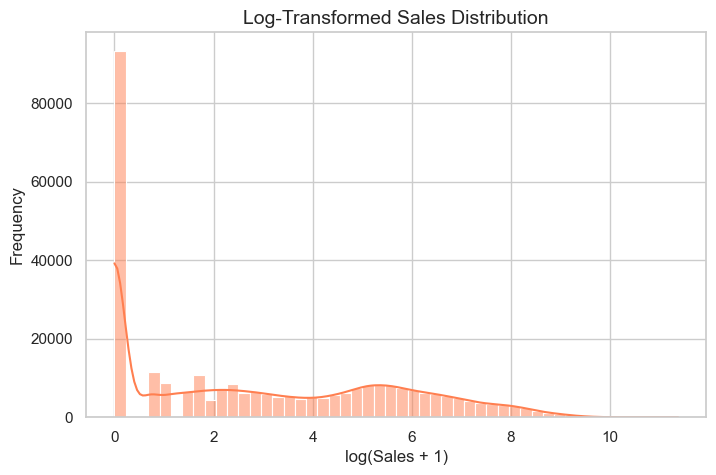

In [19]:
# Log scale view (because sales often have long tails)
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(df_sample['sales']), bins=50, kde=True, color='coral')
plt.title("Log-Transformed Sales Distribution", fontsize=14)
plt.xlabel("log(Sales + 1)")
plt.ylabel("Frequency")
plt.show()

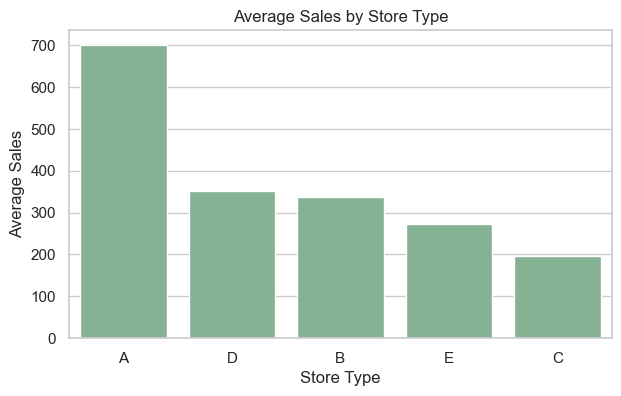

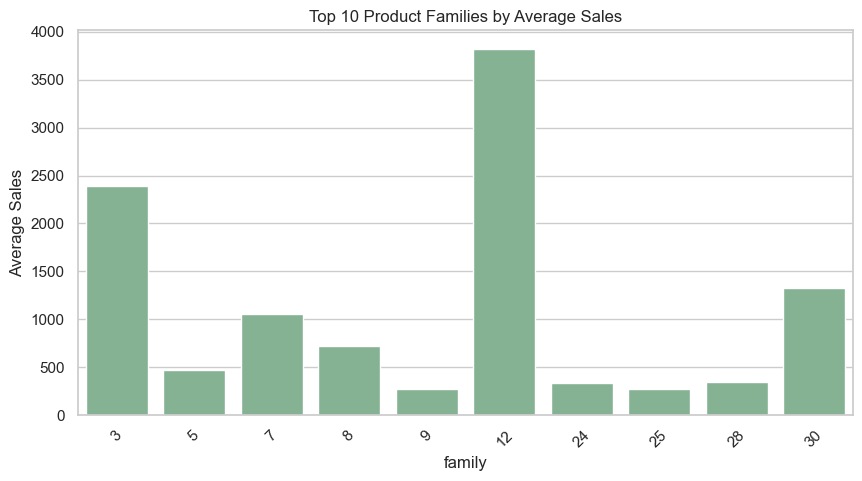

In [20]:
# Average Sales by Store Type and Product Family
store_type_col = 'type_x' if 'type_x' in df_sample.columns else 'type'
family_col = 'family' if 'family' in df_sample.columns else None

if store_type_col and family_col:
    # Average sales by store type
    sales_by_type = df_sample.groupby(store_type_col)['sales'].mean().sort_values(ascending=False)
    plt.figure(figsize=(7,4))
    sns.barplot(x=sales_by_type.index, y=sales_by_type.values)
    plt.title("Average Sales by Store Type")
    plt.ylabel("Average Sales")
    plt.xlabel("Store Type")
    plt.show()

    # Top 10 families by average sales
    top_families = df_sample.groupby(family_col)['sales'].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_families.index, y=top_families.values)
    plt.title("Top 10 Product Families by Average Sales")
    plt.xticks(rotation=45)
    plt.ylabel("Average Sales")
    plt.show()


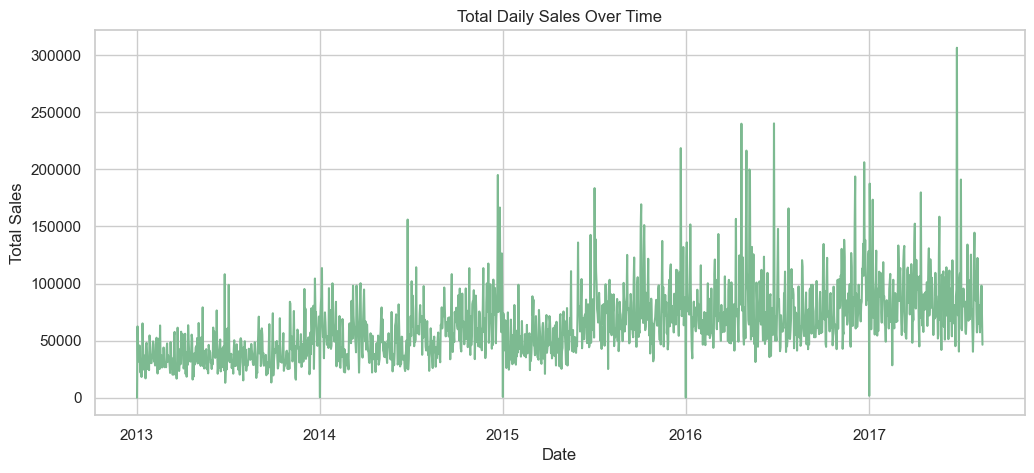

In [21]:
# Sales Over Time
daily_sales = df_sample.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(x='date', y='sales', data=daily_sales)
plt.title("Total Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()

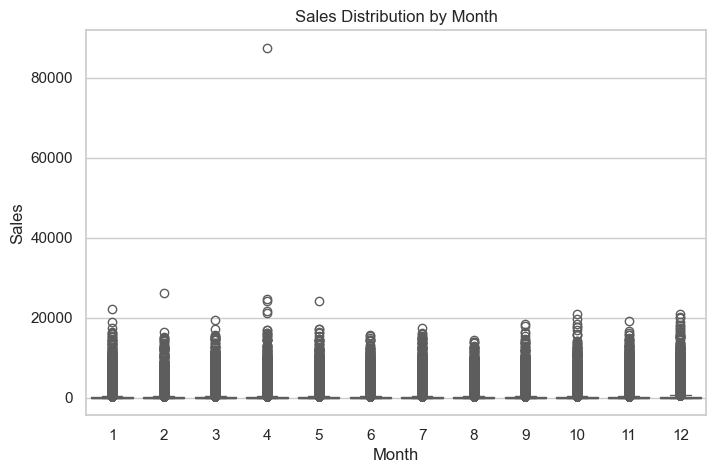

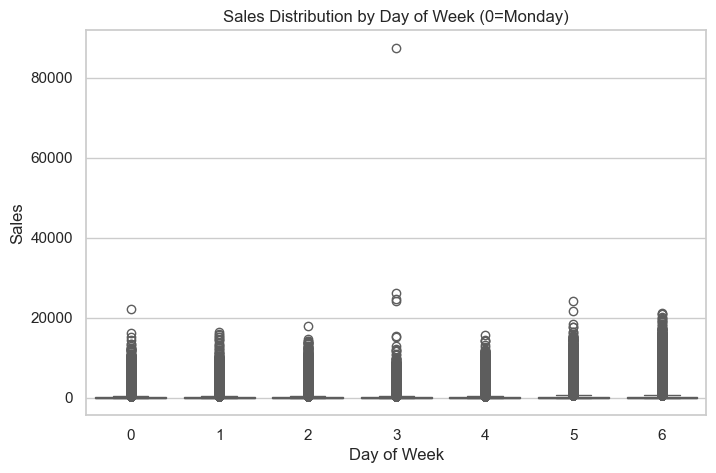

In [22]:
# Seasonality Patterns
# By month
plt.figure(figsize=(8,5))
sns.boxplot(x='month', y='sales', data=df_sample)
plt.title("Sales Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()
# By day of week
plt.figure(figsize=(8,5))
sns.boxplot(x='day_of_week', y='sales', data=df_sample)
plt.title("Sales Distribution by Day of Week (0=Monday)")
plt.xlabel("Day of Week")
plt.ylabel("Sales")
plt.show()

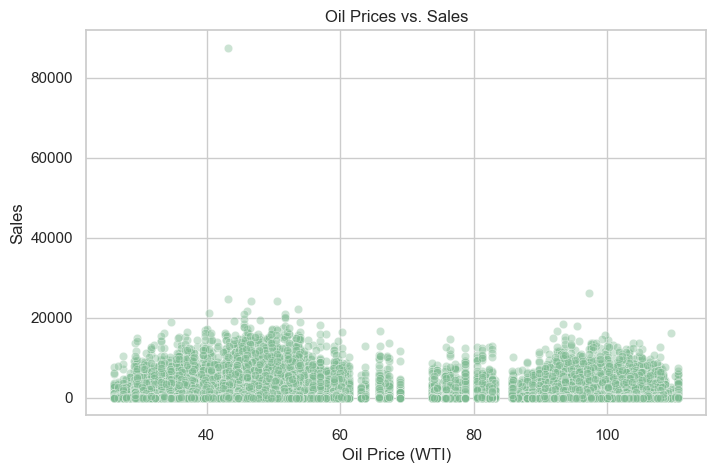

In [23]:
# Oil Prices vs Sales
if 'dcoilwtico' in df_sample.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='dcoilwtico', y='sales', data=df_sample, alpha=0.4)
    plt.title("Oil Prices vs. Sales")
    plt.xlabel("Oil Price (WTI)")
    plt.ylabel("Sales")
    plt.show()

In [24]:
# Feature Engineering & Baseline Modeling
# Select a subset of columns for modeling
features = [
    'store_nbr', 'family', 'onpromotion', 'year', 'month', 'day', 
    'day_of_week', 'dcoilwtico', 'type_x'
]

In [25]:
# Filter the dataframe to only include rows where these columns are not missing
df_model = df_sample.dropna(subset=features + ['sales'])

In [26]:
# Split features and target
X = df_model[features]
y = df_model['sales']

In [27]:
# Encode any remaining categorical columns
cat_cols = X.select_dtypes(include=['object']).columns
print("Encoding categorical columns:", list(cat_cols))

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

Encoding categorical columns: ['type_x']


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6980\1269143318.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))


In [28]:
# Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Train a baseline Random Forest model
model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [31]:
# Predictions and evaluation
y_pred = model.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
print(f"✅ Baseline Random Forest RMSE: {rmse:.2f}")


✅ Baseline Random Forest RMSE: 318.05
